In [246]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [247]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [248]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(url)



In [249]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [250]:
#df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [251]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [252]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [253]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [254]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [255]:
len(y_val)

1409

In [256]:
(y_val == churn_decision).sum()

np.int64(1132)

In [257]:
from sklearn.metrics import accuracy_score

In [258]:
thresholds = np.linspace(0,1,21)

scores= []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)

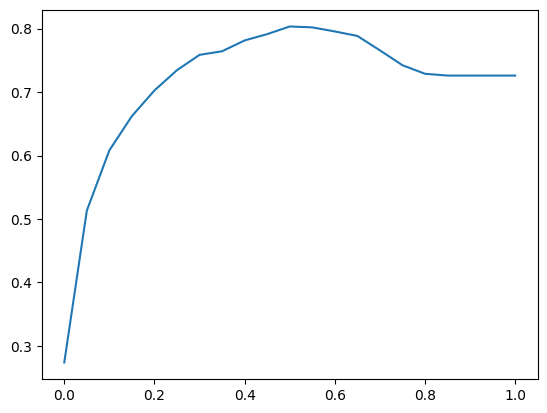

In [259]:
plt.plot(thresholds, scores)

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [260]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [261]:
t = 0.5
predict_positive = ( y_pred >= t)
predict_negative = ( y_pred < t)

In [262]:
predict_positive[:5]

array([False, False, False,  True, False])

In [263]:
actual_positive[:5]

array([False, False, False,  True, False])

In [264]:
tp = (predict_positive & actual_positive).sum() #mira los elementos de ambas listas que son True
tp

np.int64(212)

In [265]:
tn = (predict_negative & actual_negative).sum() #mira los elementos de ambas listas que son True
tn

np.int64(920)

In [266]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
fp, fn

(np.int64(103), np.int64(174))

In [267]:
confusion_matrix = np.array ([
    [tn, fp],
    [fn, tp]

])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [268]:
(confusion_matrix / confusion_matrix.sum()).round(3)*100


array([[65.3,  7.3],
       [12.3, 15. ]])

## 4.4 Precision and Recall

In [269]:
( tp + tn ) / ( tp + tn + fn + fp)

np.float64(0.8034066713981547)

In [270]:
precission = tp / (tp +fp)
precission

np.float64(0.6730158730158731)

In [271]:
recall = tp / (tp + fn)
recall

np.float64(0.5492227979274611)

## 4.5 ROC Curves

### TPR and FRP

In [272]:
tpr= tp / ( tp + fn)
tpr

np.float64(0.5492227979274611)

In [273]:
fpr = fp / ( tn + fp)


In [274]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    
    predict_positive = ( y_pred >= t)
    predict_negative = ( y_pred < t)

    tn = (predict_negative & actual_negative).sum()
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))


In [275]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,532,20,491
20,0.2,339,372,47,651
30,0.3,293,247,93,776
40,0.4,253,175,133,848
50,0.5,212,103,174,920
60,0.6,151,53,235,970
70,0.7,69,13,317,1010
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [276]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['tpr'] = df_scores.tp / ( df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / ( df_scores.tn + df_scores.fp)

In [277]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,532,20,491,0.948187,0.520039
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,293,247,93,776,0.759067,0.241447
40,0.4,253,175,133,848,0.655440,0.171065
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


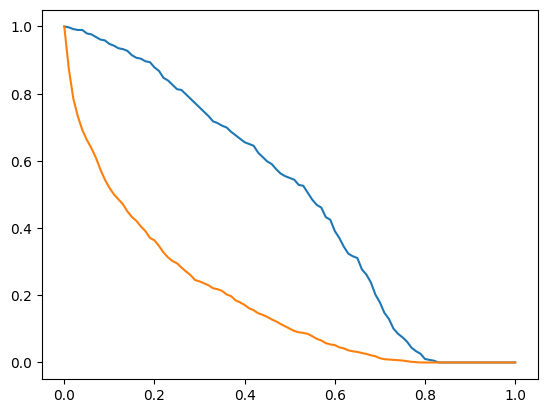

In [278]:
plt.plot(df_scores.threshold,df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold,df_scores['fpr'], label='FPR')

### Random model

In [279]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))

In [280]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [281]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    
    thresholds = np.linspace(0,1,101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        
        predict_positive = ( y_pred >= t)
        predict_negative = ( y_pred < t)
    
        tn = (predict_negative & actual_negative).sum()
        tp = (predict_positive & actual_positive).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp / ( df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / ( df_scores.tn + df_scores.fp)

    return df_scores

In [282]:
df_random = tpr_fpr_dataframe(y_val, y_rand)

In [283]:
df_random[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


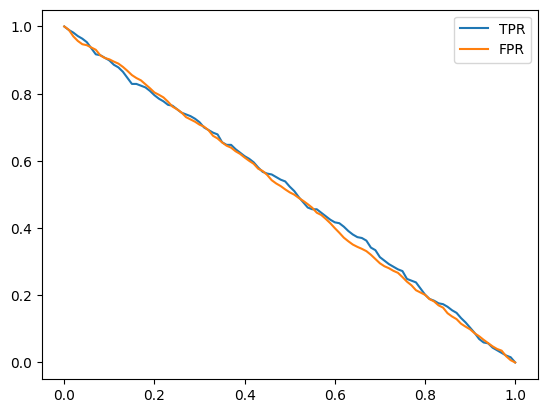

In [284]:
plt.plot(df_random.threshold,df_random['tpr'], label='TPR')
plt.plot(df_random.threshold,df_random['fpr'], label='FPR')
plt.legend()

### Ideal model

In [285]:
num_neg = (y_val == 0 ).sum()
num_pos = (y_val == 1 ).sum()
num_neg, num_pos 

(np.int64(1023), np.int64(386))

In [286]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [287]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [288]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [289]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [290]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


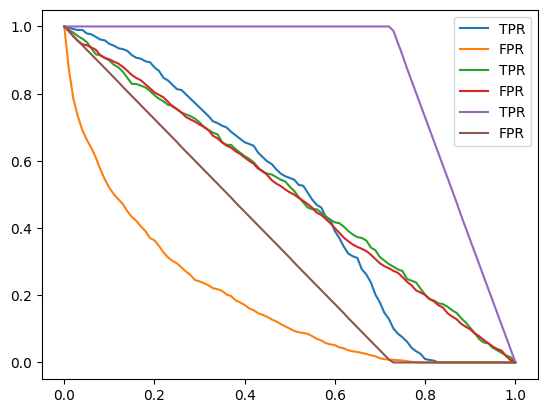

In [291]:
plt.plot(df_scores.threshold,df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold,df_scores['fpr'], label='FPR')

plt.plot(df_random.threshold,df_random['tpr'], label='TPR')
plt.plot(df_random.threshold,df_random['fpr'], label='FPR')

plt.plot(df_ideal.threshold,df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold,df_ideal['fpr'], label='FPR')

plt.legend()

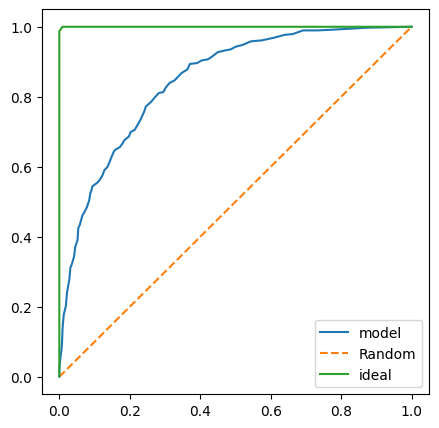

In [292]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
#plt.plot(df_random.fpr, df_random.tpr, label='random')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.legend()

In [293]:
from sklearn.metrics import roc_curve

In [294]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

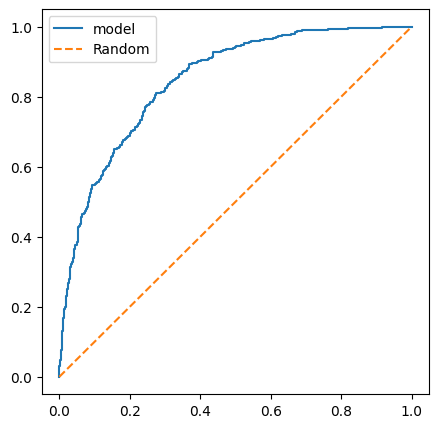

In [295]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
#plt.plot(df_random.fpr, df_random.tpr, label='random')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.legend()

### Putting everything together

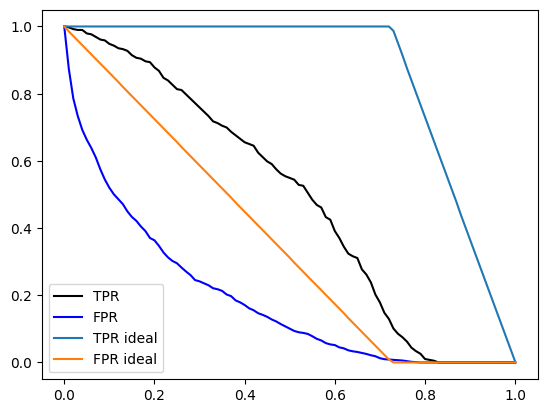

In [296]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

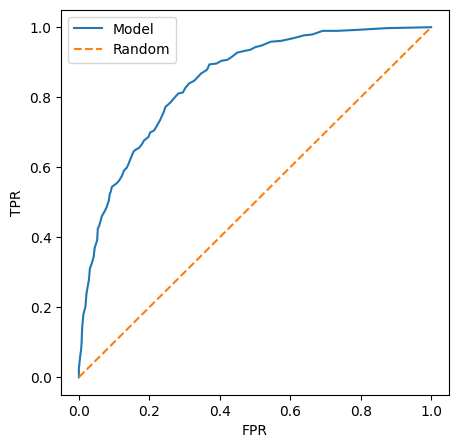

In [297]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [298]:
from sklearn.metrics import roc_curve

In [299]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

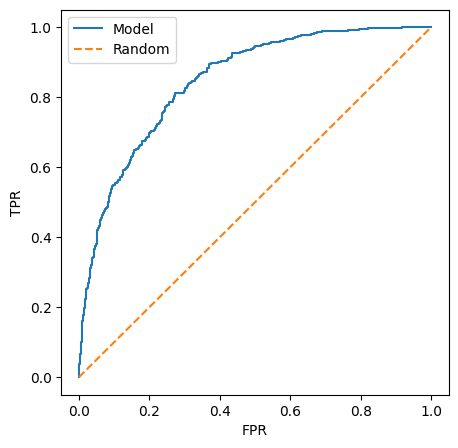

In [300]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [301]:
from sklearn.metrics import auc

In [302]:
auc(fpr, tpr)

0.846286701208981

In [303]:
auc(df_scores.fpr, df_scores.tpr)

0.8460309260075264

In [304]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [310]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.846286701208981

In [311]:
from sklearn.metrics import roc_auc_score

In [312]:
roc_auc_score(y_val, y_pred)

0.846286701208981

In [315]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [316]:
import random

In [326]:
n = 10000
success = 0

for i in range(n):

    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success +1
success / n


0.8459

In [330]:
n = 50000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84902)

array([False, False,  True, ...,  True, False,  True], shape=(10000,))

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [121]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [123]:
dv, model = train(df_train, y_train, C=0.001)

In [110]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [98]:
y_pred = predict(df_val, dv, model)

In [99]:
from sklearn.model_selection import KFold

In [112]:
!pip install tqdm

You should consider upgrading via the '/home/alexey/.pyenv/versions/3.8.11/bin/python3.8 -m pip install --upgrade pip' command.


In [113]:
from tqdm.auto import tqdm

In [129]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [133]:
scores

[0.8419433083969826,
 0.8458047775129122,
 0.8325145494681918,
 0.8325466042079682,
 0.8525462018763139]

In [131]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week